In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


2025-09-08 23:04:54.191871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 23:04:54.598912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-08 23:04:55.999731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
num_classes = len(le.classes_)
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
print("Binary target class distribution:")
print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Binary target shape: (441043,)
Multi-class target shape: (441043,)
Binary target class distribution:
Counter({np.int64(0): 300000, np.int64(1): 141043})
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [3]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X,
    y_multiclass_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass_encoded  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Multi-class target class distribution (train):")
print(Counter(np.argmax(y_train_multi, axis=1)))
print("Multi-class target class distribution (test):")
print(Counter(np.argmax(y_test_multi, axis=1)))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_multiclass labels shape: (352834, 9)
X_test  shape: (88209, 44)
y_test_multiclass labels shape: (88209, 9)
Multi-class target class distribution (train):
Counter({np.int64(5): 240000, np.int64(0): 16000, np.int64(6): 16000, np.int64(7): 16000, np.int64(8): 16000, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(4): 834})
Multi-class target class distribution (test):
Counter({np.int64(5): 60000, np.int64(1): 4000, np.int64(3): 4000, np.int64(6): 4000, np.int64(0): 4000, np.int64(8): 4000, np.int64(7): 4000, np.int64(2): 4000, np.int64(4): 209})
Scaling complete.


In [4]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_multi, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_multi, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("multi target distribution:", Counter(np.argmax(y_train_multi, axis=1)))

# counters
print("Class distribution in y_train_seq:", Counter(np.argmax(y_train_seq, axis=1)))
print("Class distribution in y_test_seq:", Counter(np.argmax(y_test_seq, axis=1)))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.

In [7]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Convert one-hot to integer labels for y_train_seq
y_train_seq_labels = np.argmax(y_train_seq, axis=1)

# Apply ADASYN instead of SMOTE
adasyn = ADASYN(
    sampling_strategy={4: 10000},  # Only oversample class 4
    random_state=42,
    n_neighbors=5
)
X_train_res, y_train_res = adasyn.fit_resample(
	X_train_seq.reshape(X_train_seq.shape[0], -1),  # Flatten for ADASYN
	y_train_seq_labels
)
X_train_res = X_train_res.reshape(X_train_res.shape[0], TIMESTEPS, X_train_seq.shape[2])  # Reshape back to sequences
y_train_res = to_categorical(y_train_res, num_classes=y_train_seq.shape[1])  # One-hot encode	
print("After ADASYN:")
print("Resampled X_train shape:", X_train_res.shape)
print("Resampled y_train shape:", y_train_res.shape)
print("Resampled class distribution:", Counter(np.argmax(y_train_res, axis=1)))

After ADASYN:
Resampled X_train shape: (361902, 20, 44)
Resampled y_train shape: (361902, 9)
Resampled class distribution: Counter({np.int64(5): 239988, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(6): 15999, np.int64(8): 15999, np.int64(0): 15999, np.int64(7): 15997, np.int64(4): 9920})


In [8]:
from sklearn.utils import shuffle

X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_res, y_train_res, random_state=42)
# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(np.argmax(y_train_seq_final, axis=1))}")
print(f"y_val_seq distribution: {Counter(np.argmax(y_val_seq, axis=1))}")

Final training shapes:
X_train_seq_final shape: (289522, 20, 44)
y_train_seq_final shape: (289522, 9)
X_val_seq shape: (72380, 20, 44)
y_val_seq shape: (72380, 9)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(5): 192140, np.int64(3): 12871, np.int64(7): 12853, np.int64(2): 12846, np.int64(8): 12748, np.int64(6): 12738, np.int64(1): 12701, np.int64(0): 12680, np.int64(4): 7945})
y_val_seq distribution: Counter({np.int64(5): 47848, np.int64(0): 3319, np.int64(1): 3299, np.int64(6): 3261, np.int64(8): 3251, np.int64(2): 3154, np.int64(7): 3144, np.int64(3): 3129, np.int64(4): 1975})


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,        # Key Change: Much lower patience
    mode='min',
    restore_best_weights=True, # This is correct and crucial
    verbose=1
)

# Reduce learning rate after 2 epochs of no improvement
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,        # Usually, LR reduction has a lower patience than early stopping
    min_lr=1e-6,
    verbose=1
)

frequencies = np.sum(y_train_seq_final, axis=0)
median_freq = np.median(frequencies)
class_weights = {cls: median_freq / count for cls, count in enumerate(frequencies)}

print("Class weights for training:", class_weights)

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


I0000 00:00:1757352612.141047   16900 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,113 (1.34 MB)

 Trainable params: 351,113 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Class weights for training: {0: np.float64(1.0053627760252366), 1: np.float64(1.003700496023935), 2: np.float64(0.9923711661217499), 3: np.float64(0.9904436329733509), 4: np.float64(1.6045311516677156), 5: np.float64(0.06634745498074321), 6: np.float64(1.000785052598524), 7: np.float64(0.9918307010036568), 8: np.float64(1.0)}
Epoch 1/10


2025-09-08 23:15:25.683706: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


4524/4524 ━━━━━━━━━━━━━━━━━━━━ 178s 37ms/step - accuracy: 0.5899 - auc: 0.9164 - loss: 0.4289 - precision: 0.7733 - recall: 0.4758 - val_accuracy: 0.8026 - val_auc: 0.9681 - val_loss: 0.6772 - val_precision: 0.8443 - val_recall: 0.7690 - learning_rate: 1.0000e-04
Epoch 2/10
4524/4524 ━━━━━━━━━━━━━━━━━━━━ 169s 37ms/step - accuracy: 0.8260 - auc: 0.9791 - loss: 0.1776 - precision: 0.8577 - recall: 0.7979 - val_accuracy: 0.9046 - val_auc: 0.9880 - val_loss: 0.3613 - val_precision: 0.9198 - val_recall: 0.8950 - learning_rate: 1.0000e-04
Epoch 3/10
4524/4524 ━━━━━━━━━━━━━━━━━━━━ 170s 38ms/step - accuracy: 0.8868 - auc: 0.9884 - loss: 0.1075 - precision: 0.9015 - recall: 0.8735 - val_accuracy: 0.9296 - val_auc: 0.9913 - val_loss: 0.2761 - val_precision: 0.9365 - val_recall: 0.9224 - learning_rate: 1.0000e-04
Epoch 4/10
4524/4524 ━━━━━━━━━━━━━━━━━━━━ 170s 38ms/step - accuracy: 0.9094 - auc: 0.9912 - loss: 0.0814 - precision: 0.9190 - recall: 0.8999 - val_accuracy: 0.9339 - val_auc: 0.9927 - v

['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'password' 'scanning'
 'xss']
Encoded class 0 -> backdoor
Encoded class 1 -> ddos
Encoded class 2 -> dos
Encoded class 3 -> injection
Encoded class 4 -> mitm
Encoded class 5 -> normal
Encoded class 6 -> password
Encoded class 7 -> scanning
Encoded class 8 -> xss
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3997
           1       0.91      0.96      0.94      3998
           2       0.93      0.97      0.95      4000
           3       0.88      0.98      0.93      3999
           4       0.19      0.99      0.31       209
           5       1.00      0.96      0.98     59991
           6       0.94      0.99      0.97      3998
           7       0.93      1.00      0.96      3999
           8       0.94      0.99      0.96      3999

    accuracy                           0.97     88190
   macro avg       0.86      0.98      0.89

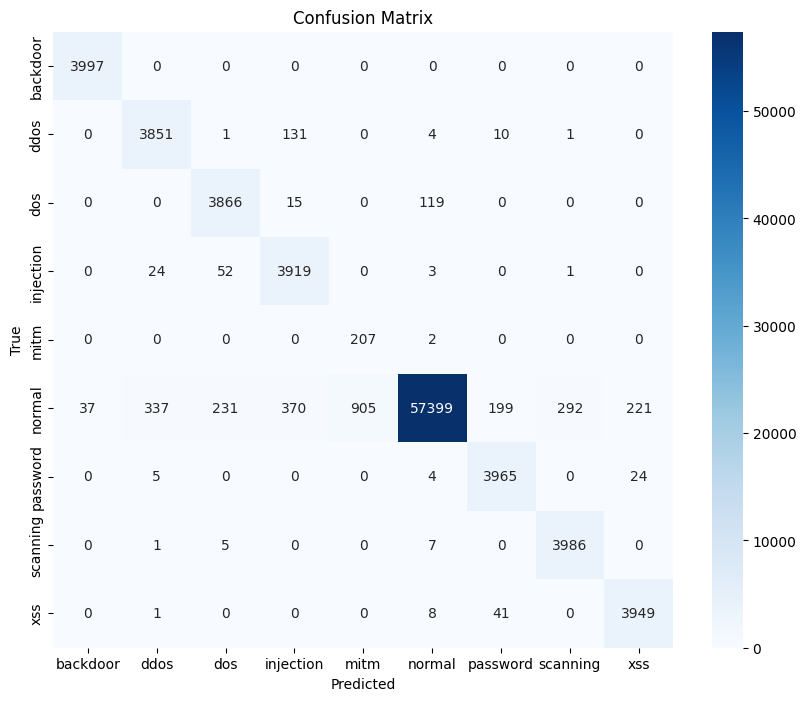

    Class      FNR      FPR
 backdoor 0.000000 0.000439
     ddos 0.036768 0.004371
      dos 0.033500 0.003433
injection 0.020005 0.006129
     mitm 0.009569 0.010286
   normal 0.043206 0.005213
 password 0.008254 0.002969
 scanning 0.003251 0.003492
      xss 0.012503 0.002910


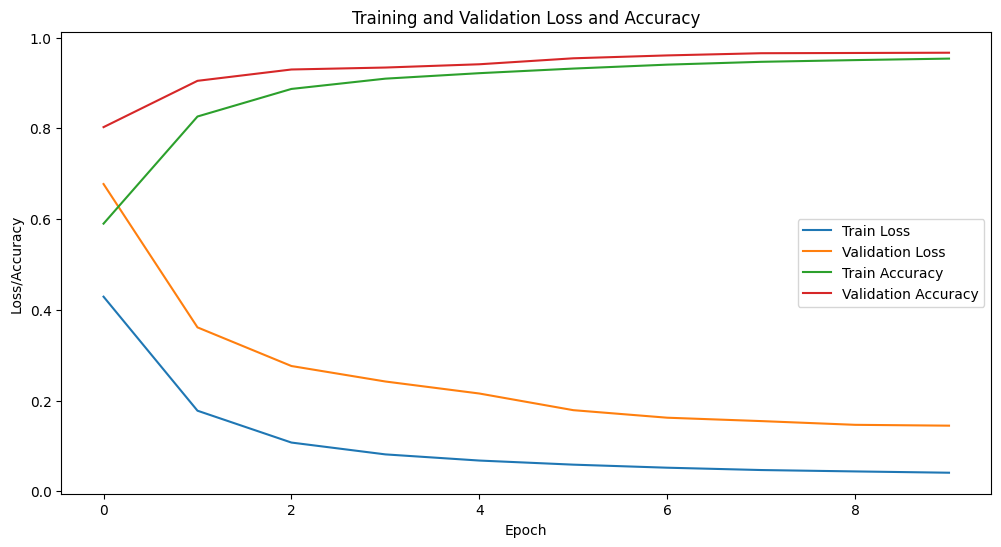

In [10]:
import seaborn as sns

# original class labels (what was in df[TARGET_TYPE])
print(type_encoder.classes_)

# numeric codes assigned
for i, cls in enumerate(type_encoder.classes_):
    print(f"Encoded class {i} -> {cls}")


# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=type_encoder.classes_,
            yticklabels=type_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))
# print("False Negative Rate (FNR) per class:", fnr)
# print("False Positive Rate (FPR) per class:", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [2]:
# Hyperparameter Tuning with Bayesian Optimization (BayesSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

def build_bilstm_model(
    lstm_units=64,
    hidden_layer=32,
    dropout=0.2,
    learning_rate=0.001,
    input_shape=(30, 44)
):
    model = Sequential([
        Bidirectional(LSTM(int(lstm_units*2), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.2), input_shape=input_shape),
        LayerNormalization(),
        Dropout(dropout),
        Bidirectional(LSTM(int(lstm_units))),
        LayerNormalization(),
        Dropout(dropout),
        Dense(int(hidden_layer), activation='relu'),
        Dense(9, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.metrics import make_scorer

def constrained_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_true, y_pred)
        # Constraints: FNR ≤ 0.01, FPR ≤ 0.5, Accuracy > 0.90
        if fnr <= 0.01 and fpr <= 0.5 and acc > 0.90:
            print(f"Valid model found: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return acc
        else:
            print(f"Model rejected: FNR={fnr}, FPR={fpr}, Acc={acc}")
            return 0
    else:
        # If confusion matrix is not 2x2, return 0
        return 0

constrained_scorer = make_scorer(constrained_score)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

# Wrap the model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=build_bilstm_model,
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2]),
    verbose=1
)

# Define the hyperparameter search space
param_space = {
    'model__lstm_units': Integer(64, 128),
    'model__hidden_layer': Integer(16, 32),
    'model__dropout': Real(0.2, 0.4),
    'model__learning_rate': Real(1e-4, 1e-2, prior='log-uniform'),
    'batch_size': Categorical([64, 128]),
    'epochs': Integer(5, 10)
}

opt = BayesSearchCV(
    estimator=keras_clf,
    search_spaces=param_space,
    n_iter=10,
    # scoring=constrained_scorer,
    scoring="accuracy",
    # cv=2,
    cv=cv_strategy,
    n_jobs=1,
    verbose=2,
    refit=True
)

# Convert one-hot encoded targets to integer labels
y_train_seq_final_labels = np.argmax(y_train_seq_final, axis=1)
y_test_seq_labels = np.argmax(y_test_seq, axis=1)

# Fit the optimizer (this may take a while)
opt.fit(X_train_seq_final, y_train_seq_final_labels, callbacks=[early_stopping, reduce_lr], validation_split=0.2, class_weight=class_weight_dict, verbose=1)

print('Best parameters:', opt.best_params_)
print('Best cross-validation accuracy:', opt.best_score_)

# Evaluate on test set
test_score = opt.score(X_test_seq, y_test_seq_labels)
print('Test set accuracy:', test_score)

NameError: name 'np' is not defined

In [ ]:
# use the best params obtained from the above bayes search to train the model again and evaluate on test set.
# Extract best parameters
best_params = opt.best_params_
# Build model with best parameters
model = build_bilstm_model(
    lstm_units=best_params['model__lstm_units'],
    hidden_layer=best_params['model__hidden_layer'],
    dropout=best_params['model__dropout'],
    learning_rate=best_params['model__learning_rate'],
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])
)

# Train the model
history = model.fit(
    X_train_seq_final, y_train_seq_final_labels,
    validation_data=(X_val_seq, np.argmax(y_val_seq, axis=1)),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate on test set
results = model.evaluate(X_test_seq, y_test_seq_labels, verbose=2)
print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 112s 49ms/step - accuracy: 0.6129 - loss: 1.0916 - val_accuracy: 0.8872 - val_loss: 0.3500 - learning_rate: 0.0011
Epoch 2/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.8926 - loss: 0.3527 - val_accuracy: 0.9314 - val_loss: 0.2390 - learning_rate: 0.0011
Epoch 3/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9157 - loss: 0.2622 - val_accuracy: 0.9371 - val_loss: 0.2284 - learning_rate: 0.0011
Epoch 4/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9264 - loss: 0.2252 - val_accuracy: 0.9384 - val_loss: 0.2118 - learning_rate: 0.0011
Epoch 5/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9275 - loss: 0.2354 - val_accuracy: 0.9588 - val_loss: 0.1803 - learning_rate: 0.0011
Epoch 6/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - accuracy: 0.9313 - loss: 0.2205 - val_accuracy: 0.9496 - val_loss: 0.1923 - learning_rate: 0.0011
Epoch 7/10
2206/2206 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step -

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3997
           1       0.90      0.96      0.93      3998
           2       0.82      0.97      0.89      4000
           3       0.91      0.96      0.93      3999
           4       0.18      0.83      0.29       209
           5       1.00      0.95      0.97     59991
           6       0.94      0.99      0.96      3998
           7       0.95      1.00      0.97      3999
           8       0.89      0.97      0.93      3999

    accuracy                           0.96     88190
   macro avg       0.84      0.96      0.87     88190
weighted avg       0.97      0.96      0.96     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3844    11   134     0     4     2     2     1]
 [    0     2  3872     1     0   124     0     0     1]
 [    0    62    84  3825     0     2     0     1    25]
 [    0     0     2   

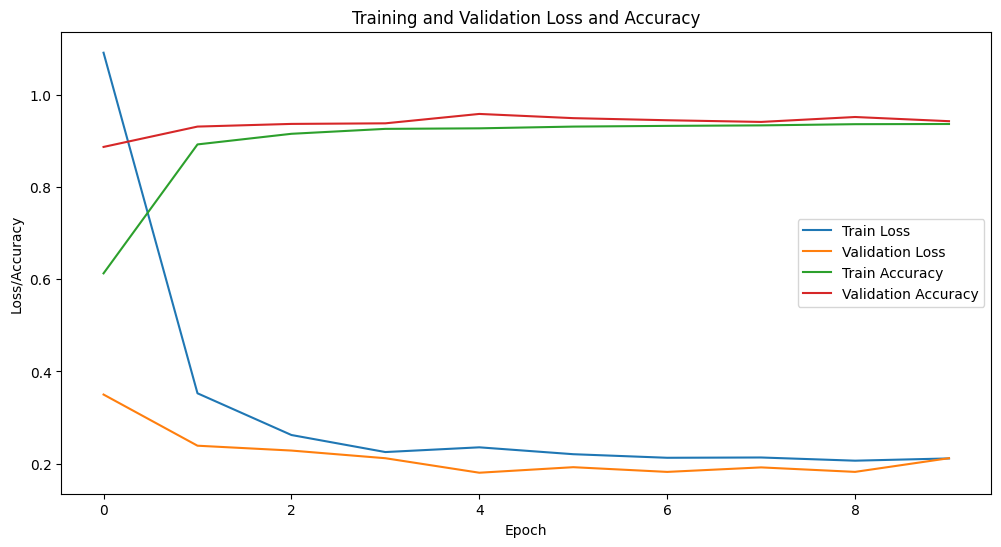

In [ ]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrics
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

#plot the validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')   
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()



In [ ]:
# Calculate FPR and FNR
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq_labels
cm = confusion_matrix(y_true_classes, y_pred_classes)

# For multi-class, calculate FNR and FPR per class
fnr = []
fpr = []
for i in range(cm.shape[0]):
	fn = cm[i, :].sum() - cm[i, i]
	tp = cm[i, i]
	fp = cm[:, i].sum() - cm[i, i]
	tn = cm.sum() - (tp + fn + fp)
	fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
	fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step
False Negative Rate (FNR) per class: [np.float64(0.0), np.float64(0.03851925962981491), np.float64(0.032), np.float64(0.04351087771942986), np.float64(0.1722488038277512), np.float64(0.05025753863079462), np.float64(0.01025512756378189), np.float64(0.004001000250062516), np.float64(0.025506376594148537)]
False Positive Rate (FPR) per class: [np.float64(0.001057095007898519), np.float64(0.0052974154313949065), np.float64(0.009989309894286733), np.float64(0.004608568611846872), np.float64(0.00916106886714177), np.float64(0.005071101812120997), np.float64(0.0031238122386925125), np.float64(0.002672494684705016), np.float64(0.005523155681723699)]


In [ ]:
import pandas as pd

# Use type_encoder.classes_ to match the order and number of classes
results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))


    Class      FNR      FPR
 backdoor 0.000000 0.001057
     ddos 0.038519 0.005297
      dos 0.032000 0.009989
injection 0.043511 0.004609
     mitm 0.172249 0.009161
   normal 0.050258 0.005071
 password 0.010255 0.003124
 scanning 0.004001 0.002672
      xss 0.025506 0.005523
